<a href="https://colab.research.google.com/github/Leo-997/-2024-T2-COMP9517-Group-try-to-best/blob/Master/9444_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP9444 Project Summary
## Project Name: Emotion Classification using Tweets
## Group: 9444Home
<div align="center">

| Name    | Student ID |
|---------|------------|
| Ziqi Wu | z5286126   |
| Xiaowen Deng     | z5457759      |
| Feier Mo     | z5449340      |
| Ziyang Wang    |z5531376      |
| Yongyi Xu  | z5499298   |
</div>

# Introduction, Motivation and Problem Statement
The project intends to improve the accuracy of emotion classification by leveraging advanced deep learning models on a dair-ai/emotion dataset of tweets. We will apply and compare four models: BERT, CNN, RNN, and GloVe+LSTM, evaluating their performance to find the most effective model for improving the accuracy of emotion classification using tweets.

Classification emotions in text is important as it provides valuable insights into users’ emotions, which has many useful applications for various fields including marketing, customer service, mental health early intervention, public policy, etc. For example, on social media platforms, if someone posts a tweet containing extremely negative emotion, the system can use the achievements of this research to detect the negative emotion, enabling timely identification and intervention.

The main challenge we address is accurately classifying emotions. Traditional sentiment analysis methods often fail to capture the subtleties of emotional expression, especially in short texts like most tweets. We aim to evaluate and compare the performance of several advanced deep learning models.
Ultimately, our project based on existing excellent related work and identifies the best-performing model, which is BERT model, for emotion classification using tweets.


# Data Sources or RL Tasks
This project use dair-ai/emotion dataset. The emotion is a text dataset containing English sentences labeled with six different emotions. This dataset is available on the Hugging Face datasets platform and can be loaded using the Python datasets library, which can be found at https://huggingface.co/datasets/dair-ai/emotion. This dataset can be used to train and evaluate models for analysis, emotion detection, and natural language processing tasks.


# Exploratory Analysis of Data or RL Tasks

The labels in the dataset include six classes of emotions: anger, fear, joy, love, sadness, and surprise. Each data entry consists of a tweet and a label indicating the emotion. The dataset comprises a total of twenty thousand sentences: sixteen thousand in the training set, two thousand in the validation set, and two thousand in the test set.

We count each of the sentences that each emotion has and we can find that joy has most data and surprise has least data. We extracted the top three most frequently occurring words for each emotion. The results showed that these words are strongly associated with their respective emotions, fitting well with the intended emotional labels.

We performed slightly different pre-processing steps depending on the model being used.
We loaded the dataset using the Hugging Face datasets library, ensuring that the data is split into training, validation, and test sets.
For models like BERT, we use BERT Tokenizer to split the text into words or subwords, ensuring that the text is properly formatted for model input.
And we also cleaned the text by converting it to lowercase, removing extra whitespace, and stripping leading/trailing whitespace. This ensures consistency in the text format.


We faced some challenges in the process of finding the optimal model:

**Accurate Emotion Classification:** The main challenge is accurately classifying emotions, which requires careful consideration of model selection and training.

**Ambiguity and Sarcasm:** Sentences can contain ambiguous language, slang, and sarcasm, making it challenging for emotion classification models to interpret correctly.

**Variable Text Length:** Tweets have varying lengths, and short texts can make it difficult to capture the full context and nuances of the emotion expressed.

**Data Imbalance:** Although the dataset is relatively balanced, minor imbalances exist (e.g., more 'joy' sentences than 'surprise' sentences). Ensuring the model performs well across all classes requires careful handling of these imbalances.


# Models and Methods

In this experiment, we used four models, among which the BERT model worked best. Next, we will show these four methods one by one.

## 1.RNN

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed for sequential data, where the order of the data points is important. Unlike traditional feed forward neural networks, RNNs have connections that form directed cycles, allowing them to maintain a hidden state that can capture information from previous inputs in the sequence. This makes RNNs particularly well-suited for tasks involving time series, language modeling, and other sequential data.

this is the architecture:

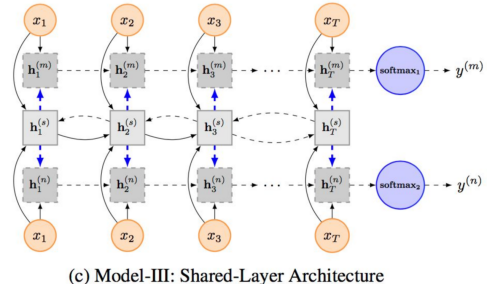

https://i-blog.csdnimg.cn/blog_migrate/27f40e6beaf787ea02e9ce06b97ebdb9.png

In [ ]:
import torch
from datasets import load_dataset
import re
from torch import nn
from transformers import BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_dataset("dair-ai/emotion", "split")
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Process training, validation, and test datasets
train_texts = [preprocess_text(text) for text in train_dataset['text']]
val_texts = [preprocess_text(text) for text in val_dataset['text']]
test_texts = [preprocess_text(text) for text in test_dataset['text']]

# Labels
train_labels = train_dataset['label']
val_labels = val_dataset['label']
test_labels = test_dataset['label']

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data encoding function
def encode_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Encode training, validation, and test datasets
train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)
test_encodings = encode_data(test_texts, test_labels, tokenizer)

# Define multi-layer bidirectional RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, num_layers=2, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)  # hidden_dim * 2 because of bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, hidden = self.rnn(embedded)
        out = self.dropout(hidden[-2:].transpose(0, 1).contiguous().view(hidden.size(1), -1))  # concatenate last forward and backward hidden states
        logits = self.fc(out)
        return logits

# Get vocabulary size
vocab_size = tokenizer.vocab_size

# Define model
model = RNNModel(vocab_size, embed_dim=128, hidden_dim=256, num_labels=6, num_layers=2, dropout=0.5)
model.to(device)  # Move model to GPU

# Define dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings['input_ids'])

The Simple RNN model architecture includes:
1.Embedding Layer: This layer converts the input text tokens into dense vectors. Pretrained GloVe embeddings are used to initialize the embedding layer, ensuring the model benefits from pretrained word representations.
2.Bidirectional LSTM Layer: A two-layer bidirectional Long Short-Term Memory (LSTM) network processes the embedded text. This allows the model to capture dependencies from both directions in the text.
3.Fully Connected Layer: The output from the LSTM is passed through a fully connected (linear) layer to produce the final classification logits for the six emotion categories.

In [ ]:
# Training function with early stopping
def train_model(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, patience):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping mechanism
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

The RNN models is followed by these steps:Loading the dataset using a suitable library;Displaying the first few rows to get a sense of the data;Checking for missing values and data inconsistencies.;Analyzing the class distribution to understand the balance of the dataset;Tokenizing the text data.;Creating a word-to-index dictionary;Padding the sequences to ensure they have the same length;Downloading and loading the embedding file;Creating an embedding matrix that maps our vocabulary to the pretrained embeddings;Initialize the data;Define methods to get the length of the dataset and to get an item by index;Splitting the dataset into training and validation sets;Creating DataLoader objects for both sets;Defining the loss function and optimizer;Iterating through the training data in epochs;Updating the model parameters based on the loss;Passing the validation data through the model;Calculating performance metrics such as accuracy, precision, recall, and F1 score;Creating the confusion matrix;Generating the classification report.

d:\python3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/30, Train Loss: 1.6142, Train Accuracy: 0.3123, Validation Loss: 1.5886, Validation Accuracy: 0.3625
Epoch 2/30, Train Loss: 1.5849, Train Accuracy: 0.3468, Validation Loss: 1.5307, Validation Accuracy: 0.4105
Epoch 3/30, Train Loss: 1.5164, Train Accuracy: 0.4083, Validation Loss: 1.4939, Validation Accuracy: 0.4405
Epoch 4/30, Train Loss: 1.4312, Train Accuracy: 0.4579, Validation Loss: 1.4212, Validation Accuracy: 0.4645
Epoch 5/30, Train Loss: 1.3412, Train Accuracy: 0.5051, Validation Loss: 1.3658, Validation Accuracy: 0.5160
Epoch 6/30, Train Loss: 1.2607, Train Accuracy: 0.5481, Validation Loss: 1.2850, Validation Accuracy: 0.5535
Epoch 7/30, Train Loss: 1.1836, Train Accuracy: 0.5840, Validation Loss: 1.2570, Validation Accuracy: 0.5635
Epoch 8/30, Train Loss: 1.1073, Train Accuracy: 0.6090, Validation Loss: 1.2425, Validation Accuracy: 0.5540
Epoch 9/30, Train Loss: 1.0309, Train Accuracy: 0.6438, Validation Loss: 1.1538, Validation Accuracy: 0.6135
Epoch 10/30, Train 

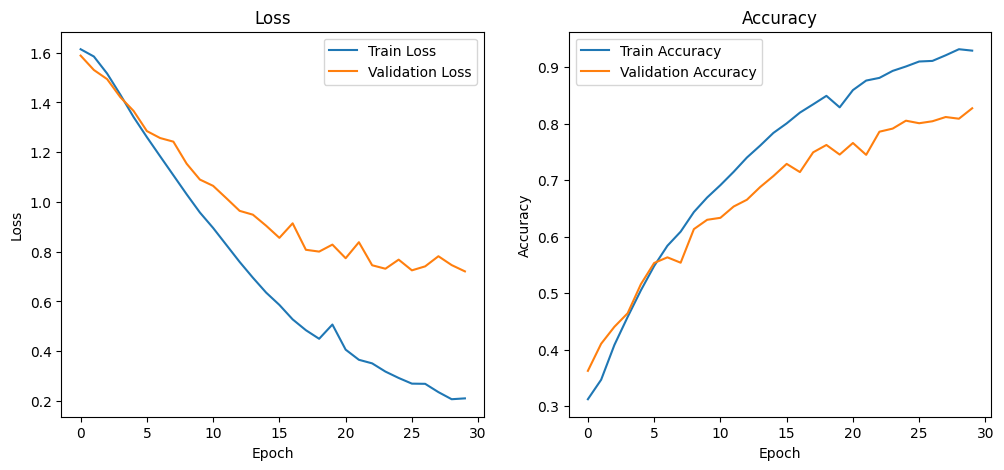

Test Accuracy: 0.7915
              precision    recall  f1-score   support

     sadness       0.81      0.90      0.85       581
         joy       0.84      0.85      0.85       695
        love       0.57      0.50      0.53       159
       anger       0.81      0.71      0.76       275
        fear       0.78      0.73      0.76       224
    surprise       0.48      0.41      0.44        66

    accuracy                           0.79      2000
   macro avg       0.72      0.68      0.70      2000
weighted avg       0.79      0.79      0.79      2000



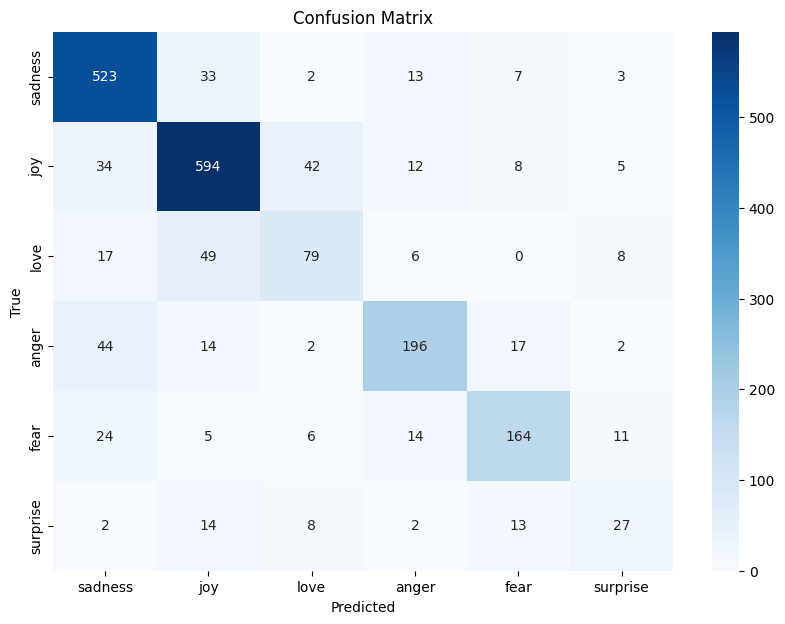

In [ ]:
def evaluate_model(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    print(f"Test Accuracy: {correct / total}")
    print(classification_report(true_labels, predictions, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Train the model with early stopping patience set to 5
train_model(model, EmotionDataset(train_encodings), EmotionDataset(val_encodings), epochs=30, batch_size=16, learning_rate=0.0001, patience=5)

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load model parameters
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.to(device)  # Ensure the model is moved to the GPU
    model.eval()
    return model

# Save the model
save_model(model, "rnn_model.pth")

# Define a new model instance and load the saved parameters
model_loaded = RNNModel(vocab_size, embed_dim=128, hidden_dim=256, num_labels=6, num_layers=2, dropout=0.5)
model_loaded = load_model(model_loaded, "rnn_model.pth")

# Evaluate the model on the test dataset
evaluate_model(model_loaded, EmotionDataset(test_encodings))


Hyperparameter settings:

Number of hidden units: 128

Learning rate: 0.001

Batch size: 32

Number of training rounds: 3

Training and evaluation:

Training process

Loss function:

The cross-entropy loss function (CrossEntropyLoss) is used to measure the error between the model prediction and the actual label.

Optimization algorithm:

The Adam optimizer is used, and the learning rate is set to 0.001.

Training cycle:

Perform multiple rounds (such as 3 rounds) of training, and iterate the entire training set in each round.

In each round of training, the model forward propagates to calculate the prediction results, calculates the loss, and backpropagates to update the model parameters.

## 2.Glove+LSTM

$~~~~$GloVe (Global Vectors for Word Representation) is a word embedding algorithm developed by Pennington, Socher, and Manning at Stanford University in 2014. The core idea of GloVe model is to generate word vectors by counting the co-occurrence probability of words in large-scale corpus. GloVe uses the co-occurrence information of words in the global context, constructs a co-occurrence matrix, and obtains the vector representation of each word through matrix decomposition.
And finally to count the number of times that two words appear together.

$~~~~$The GloVe model was chosen mainly because of its excellent performance in capturing global semantic relationships between words. Unlike other embedding methods based on local context Windows, such as Word2Vec, GloVe uses statistics from the entire corpus to generate more comprehensive and semantically meaningful word vectors. This allows GloVe to better capture similarities and associations between words

In [ ]:
import gensim.downloader as api
import numpy as np
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Load pre-trained GloVe vectors
glove_vectors = api.load("glove-wiki-gigaword-50")

# Define a function that converts text to GloVe embedding
def vectorize_sentence(sentence, model, max_len):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    return pad_sequences([word_vectors], maxlen=max_len, padding='post', dtype='float32')[0]

# Load dataset
dataset_split = load_dataset("dair-ai/emotion", name="split")

# Set maximum sequence length
max_len = 50

# Convert text to GloVe embeddings
train_texts = dataset_split['train']['text']
train_labels = dataset_split['train']['label']
train_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in train_texts])

val_texts = dataset_split['validation']['text']
val_labels = dataset_split['validation']['label']
val_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in val_texts])

test_texts = dataset_split['test']['text']
test_labels = dataset_split['test']['label']
test_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in test_texts])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=6)
val_labels = to_categorical(val_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

In our project, we removed the hidden layer shown in the figure to avoid increased complexity and overfitting. After each LSTM layer, a dropout layer is added that randomly drops half of the neurons to reduce the interdependence between neurons and improve the generalization ability of the model.

The structure of Glove and LSTM are looked like this:

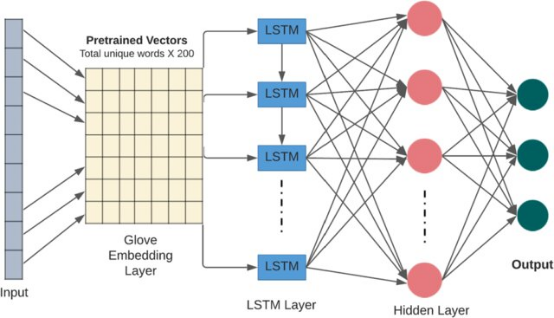

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, 50), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Training will be done on CPU.')
else:
    print('Found GPU at: {}'.format(device_name))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set device using tf.device()
with tf.device(device_name if device_name else '/cpu:0'):
    # Record training and validation loss and accuracy
    history = model.fit(train_vectors, train_labels, epochs=30, batch_size=32, validation_data=(val_vectors, val_labels), callbacks=[early_stopping])

model.save('lstm_glove_model.keras')

# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

After importing our data set, since it has been classified, we can directly start the relevant preprocessing of the training set data. First, I imported a pre-trained GloVe vector from the gensim library to improve model performance and save training time.
We then wrap a vectorize_sentence function to convert each word in each line of text data in the dataset into the corresponding GloVe vector. It is easily read by the LSTM model.
Finally, we also need to convert the emotion label into one-hot encoding format to facilitate the subsequent training of LSTM model.

Network architecture:

Input layer:
The input data is a sequence of length max_len, and the embedding dimension of each word is 50 (GloVe word vector).
The input shape is (max_len, 50).

LSTM layer:
The first layer: contains 128 hidden units, return_sequences=True means returning the output of each time step.
Dropout layer: Add a Dropout layer after the LSTM layer with a dropout rate of 0.5 to prevent overfitting.
The second layer: contains an LSTM layer with 128 hidden units, return_sequences=False means only returning the output of the last time step.
Dropout layer: Add a Dropout layer after the second LSTM layer with a dropout rate of 0.5.

Fully connected layer:
Dense layer: contains 6 units (corresponding to 6 categories), the activation function is softmax, which is used to output classification probabilities.

[=================---------------------------------] 35.5% 23.4/66.0MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.1% 55.5/66.0MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 66.0/66.0MB downloaded
GPU device not found. Training will be done on CPU.
Epoch 1/30
500/500 [==============================] - 43s 79ms/step - loss: 1.5951 - accuracy: 0.3252 - val_loss: 1.5852 - val_accuracy: 0.3440
Epoch 2/30
500/500 [==============================] - 40s 79ms/step - loss: 1.5182 - accuracy: 0.3961 - val_loss: 1.3341 - val_accuracy: 0.5155
Epoch 3/30
500/500 [==============================] - 40s 81ms/step - loss: 1.2684 - accuracy: 0.5284 - val_loss: 1.1985 - val_accuracy: 0.5490
Epoch 4/30
500/500 [==============================] - 40s 80ms/step - loss: 1.1814 - accuracy: 0.5558 - val_loss: 1.0993 - val_accuracy: 0.6065
Epoch 5/30
500/500 [==============================] - 40s 81ms/step - loss: 1.0536 - accuracy: 0.6257 - val_loss: 0.9483 - val_accuracy: 0.6580
Epoch 6/30
500/500 [==============================] - 42s 83ms/step - loss: 0.8941 - accuracy: 0.6831 - val_loss: 0.7895 - val_accuracy: 0.7250
E

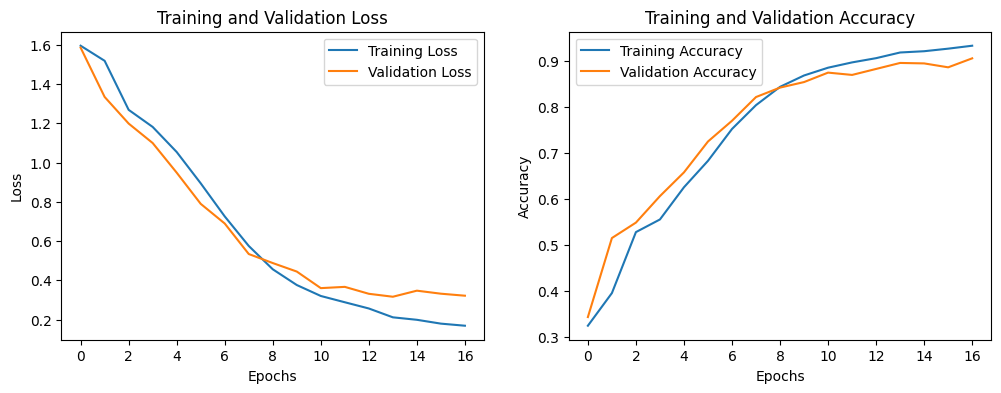

63/63 [==============================] - 2s 30ms/step - loss: 0.3699 - accuracy: 0.8805
Test Accuracy: 0.8805000185966492
63/63 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

     sadness       0.93      0.90      0.91       581
         joy       0.93      0.87      0.90       695
        love       0.72      0.90      0.80       159
       anger       0.90      0.88      0.89       275
        fear       0.87      0.87      0.87       224
    surprise       0.54      0.79      0.64        66

    accuracy                           0.88      2000
   macro avg       0.82      0.87      0.84      2000
weighted avg       0.89      0.88      0.88      2000



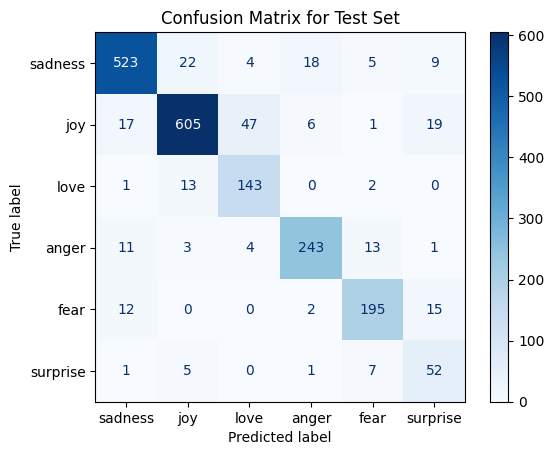

In [ ]:
# Evaluate model on test set
loss, accuracy = model.evaluate(test_vectors, test_labels)
print(f'Test Accuracy: {accuracy}')

# Predict on test set
predictions = model.predict(test_vectors)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Print detailed classification report
report = classification_report(true_labels, predicted_labels, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(report)

# Generate and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()


Hyperparameter settings

Number of hidden units: 128

Learning rate: 0.001 for the default Adam optimizer

Dropout rate: 0.5

Maximum sequence length (max_len): 50

Word vector dimension: 50

Number of categories: 6

Batch size: 32

Number of training rounds: up to 30 rounds (based on the early stopping strategy)

## 3.CNN

We have chosen to use Convolutional Neural Networks (CNNs) for the text classification task. Although CNNs were originally designed for image processing, recent research has shown that CNNs also perform well in extracting local features from text.CNNs are computationally efficient when dealing with fixed-length inputs and have a simple, computationally efficient structure that makes them well suited for processing large-scale data.

Data preprocessing begins by converting all text to lowercase and removing redundant whitespace characters. The text data was then encoded using the BERT tagger pre-training model (source https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) to convert the text into numeric vectors suitable for input into the neural network. These vectors are then fed into our custom CNN model for processing.

The code for this is as follows.

In [ ]:
import re
from transformers import BertTokenizer
from datasets import load_dataset

# Load the datasets
dataset = load_dataset("dair-ai/emotion", "split")
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocess the train, validation, and test sets
train_texts = [preprocess_text(text) for text in train_dataset['text']]
val_texts = [preprocess_text(text) for text in val_dataset['text']]
test_texts = [preprocess_text(text) for text in test_dataset['text']]

# Labels
train_labels = train_dataset['label']
val_labels = val_dataset['label']
test_labels = test_dataset['label']

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data encoding function
def encode_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Encode the train, validation, and test sets
train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)
test_encodings = encode_data(test_texts, test_labels, tokenizer)

Our CNN model includes multiple convolutional and pooling layers to efficiently extract local features of the text, followed by a fully connected layer for sentiment classification.
The structure of the model is shown below:
1. Embedding layer: the input word index is converted into word vectors, which have a dimension of 128. each word is converted into a word vector to form a two-dimensional matrix, where each row represents a vector representation of a word.
2. Convolutional Layer: consists of three convolutional layers with convolutional kernel sizes of 3, 4, and 5, respectively, and the number of output channels are all 100. the input matrix is slid over by a convolutional operation using convolutional kernels (filters). Each convolutional kernel extracts features from local regions, such as patterns of specific phrases or word groups. Convolutional kernels can detect local patterns in sentences, such as combinations of specific sentiment words and their contexts.
3. Pooling layer: A maximum pooling operation is performed on the output of each convolutional layer. The feature maps generated by the convolutional layers are downsampled using the max pooling operation to retain the most salient features in each feature map. The pooled feature maps are expanded into a one-dimensional vector and passed to the fully connected layer. The fully connected layer combines these features for higher level feature extraction.
4. Fully Connected Layer: The pooled features are joined together and the classification results are output through the fully connected layer. The output of the fully connected layer is passed to the classification layer, which uses the softmax function to convert the feature vectors into probability distributions for each category.
5. Dropout layer: used to prevent overfitting by discarding a portion of the neuron's output.

As shown in the figure:

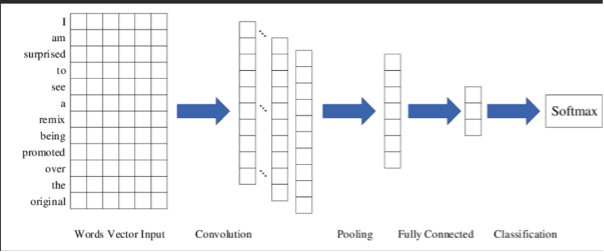

(source:https://www.researchgate.net/figure/Structure-of-CNN-based-text-classification-model_fig2_339316047)

The relevant code is as follows.



In [ ]:
import torch
from torch import nn
# Define CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_labels):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embed_dim), padding=(2, 0))
        self.conv2 = nn.Conv2d(1, 100, kernel_size=(4, embed_dim), padding=(3, 0))
        self.conv3 = nn.Conv2d(1, 100, kernel_size=(5, embed_dim), padding=(4, 0))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_labels)
    def forward(self, input_ids):
        embedded = self.embedding(input_ids).unsqueeze(1)
        conv1 = torch.relu(self.conv1(embedded)).squeeze(3)
        conv2 = torch.relu(self.conv2(embedded)).squeeze(3)
        conv3 = torch.relu(self.conv3(embedded)).squeeze(3)
        pool1 = torch.max_pool1d(conv1, conv1.size(2)).squeeze(2)
        pool2 = torch.max_pool1d(conv2, conv2.size(2)).squeeze(2)
        pool3 = torch.max_pool1d(conv3, conv3.size(2)).squeeze(2)
        out = torch.cat([pool1, pool2, pool3], 1)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")

# Get the vocabulary size
vocab_size = tokenizer.vocab_size

# Define the model
model = CNNModel(vocab_size, embed_dim=128, num_labels=6)
model.to(device)  # Move model to GPU

For training we use Adam optimiser with a learning rate of 1e-4, up to 40 training rounds and a batch size of 16 to train the model. To prevent overfitting, we set a dropout of 0.5 and introduced an early stopping strategy, setting the patience value to 5.And we plotted loss and accuracy curves for the training and validation sets to determine if the model is overfitting and underfitting.

The relevant code is as follows.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Define dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings['input_ids'])

# Training function
def train_model(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, patience):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping mechanism
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_cnn_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy charts
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

# Train the model with early stopping patience set to 5
train_model(model, EmotionDataset(train_encodings), EmotionDataset(val_encodings), epochs=40, batch_size=16, learning_rate=1e-4, patience=5)

# Load the best model
model.load_state_dict(torch.load("best_cnn_model.pth"))

We evaluate the model using a test set, calculating accuracy, classification reports, and confusion matrices.

The relevant code is as follows.

Epoch 1/40, Train Loss: 1.6794, Train Accuracy: 0.3129, Validation Loss: 1.5301, Validation Accuracy: 0.3950
Epoch 2/40, Train Loss: 1.5339, Train Accuracy: 0.3880, Validation Loss: 1.4642, Validation Accuracy: 0.4540
Epoch 3/40, Train Loss: 1.4447, Train Accuracy: 0.4347, Validation Loss: 1.3935, Validation Accuracy: 0.4765
Epoch 4/40, Train Loss: 1.3379, Train Accuracy: 0.4895, Validation Loss: 1.3003, Validation Accuracy: 0.5330
Epoch 5/40, Train Loss: 1.2263, Train Accuracy: 0.5489, Validation Loss: 1.1905, Validation Accuracy: 0.5785
Epoch 6/40, Train Loss: 1.1097, Train Accuracy: 0.5989, Validation Loss: 1.0797, Validation Accuracy: 0.6330
Epoch 7/40, Train Loss: 0.9874, Train Accuracy: 0.6502, Validation Loss: 0.9645, Validation Accuracy: 0.6660
Epoch 8/40, Train Loss: 0.8776, Train Accuracy: 0.6927, Validation Loss: 0.8643, Validation Accuracy: 0.6970
Epoch 9/40, Train Loss: 0.7744, Train Accuracy: 0.7340, Validation Loss: 0.7695, Validation Accuracy: 0.7330
Epoch 10/40, Train 

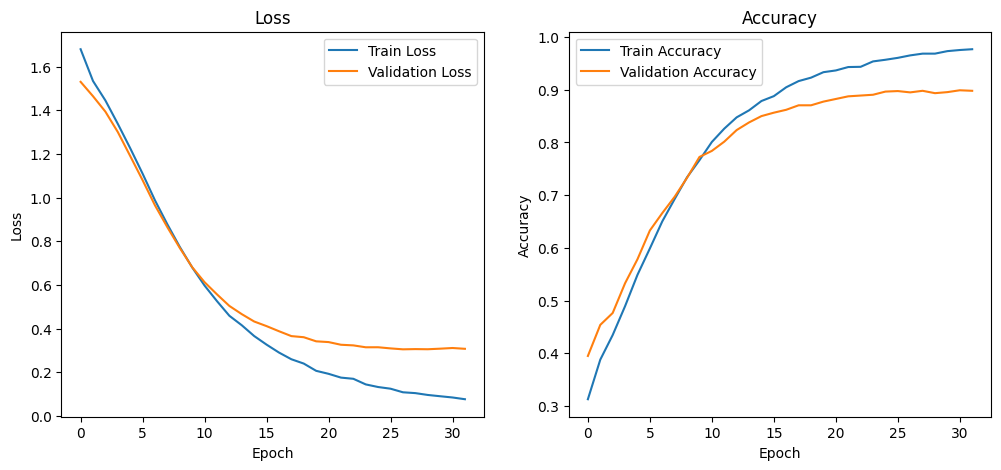

Test Accuracy: 0.8935
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.93       581
         joy       0.91      0.93      0.92       695
        love       0.80      0.74      0.77       159
       anger       0.87      0.88      0.88       275
        fear       0.89      0.85      0.87       224
    surprise       0.79      0.68      0.73        66

    accuracy                           0.89      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.89      0.89      0.89      2000



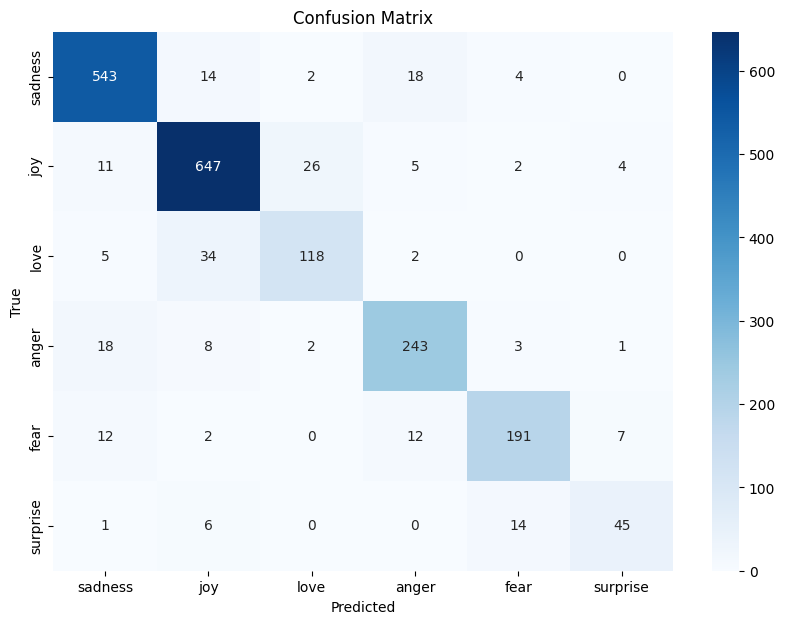

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate_model(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    print(f"Test Accuracy: {correct/total}")
    print(classification_report(true_labels, predictions, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, EmotionDataset(test_encodings))


## 4.Bert

We chose to use the BERT (Bidirectional Encoder Representations from Transformers) model for the text classification task.BERT is a pre-trained language model based on Transformer that has been pre-trained on a large amount of textual data and has performed well in many natural language BERT is a pre-trained language model based on Transformer, which has been pre-trained on a large amount of text data and performs well in many natural language processing tasks.BERT captures the contextual information of the text through a bidirectional encoder, and has a high accuracy for sentence-level classification tasks.

For data preprocessing, the text is encoded using the pre-trained BERT tagging symboliser as in CNN (source https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) . The specific code is as follows.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
# Load the datasets
dataset_split = load_dataset("dair-ai/emotion", name="split")

# Load pretrained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

# Tokenize the datasets
tokenized_train_dataset = dataset_split['train'].map(preprocess_function, batched=True)
tokenized_validation_dataset = dataset_split['validation'].map(preprocess_function, batched=True)
tokenized_test_dataset = dataset_split['test'].map(preprocess_function, batched=True)

We use a base bert model (source https://huggingface.co/transformers/v3.0.2/model_doc/bert.html) that has been pre-trained.

The structure of the model is shown in the figure:

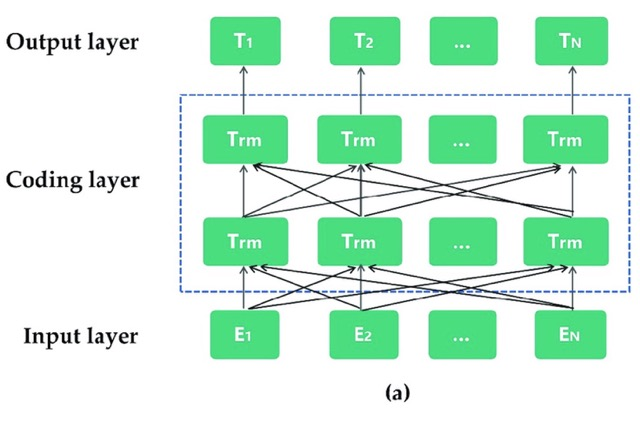

(source:https://www.researchgate.net/publication/365303285/figure/fig1/AS:11431281096598189@1668190938903/a-Structure-diagram-of-the-BERT-model-Figure-source-original-drawing-b-Input.png)

The relevant code is as follows.

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

# Loading the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

For this task, wwe fine-tuned the pre-trained BERT model using the AdamW optimiser, which combines the Adam optimiser with weight decay (weight decay = 0.01) to provide better regularisation during training. The relevant parameter codes are as follows.

In [ ]:
from transformers import TrainingArguments
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1  # Only keep the best model to save disk space
)

During the training process, we introduced an early stopping strategy by setting the patience value to 3. At the same time, the loss and accuracy were recorded for each cycle using a callback function, and the model was evaluated for over- or under-fitting by plotting graphs.

In [ ]:
import logging
from transformers import Trainer, TrainerCallback, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize logging
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize lists to record metrics
epochs = []
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Compute training metrics function
def compute_train_metrics(trainer, train_dataset):
    predictions = trainer.predict(train_dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    return compute_metrics((logits, labels))

# Logging callback
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.epoch_steps = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            epoch = state.epoch
            if epoch not in self.epoch_steps:
                self.epoch_steps.append(epoch)
                train_metrics = compute_train_metrics(trainer, trainer.train_dataset)
                training_accuracies.append(train_metrics['accuracy'])
                training_losses.append(logs['loss'])
                epochs.append(epoch)
                print(f"Epoch {epoch}: Training Accuracy: {train_metrics['accuracy']:.4f}, Training Loss: {logs['loss']:.4f}")
            if 'eval_loss' in logs and 'eval_accuracy' in logs:
                validation_losses.append(logs['eval_loss'])
                validation_accuracies.append(logs['eval_accuracy'])
                print(f"Validation Loss: {logs['eval_loss']}, Accuracy: {logs['eval_accuracy']}")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Add callbacks
trainer.add_callback(LoggingCallback())
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

# Train the model
try:
    trainer.train()
except Exception as e:
    logging.error(f"Training failed: {e}")

# Save the best model
trainer.save_model("best_model")

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_losses)), training_losses, marker='o', label='Training Loss', color='blue')
plt.plot(range(len(validation_losses)), validation_losses, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(training_accuracies)), training_accuracies, marker='o', label='Training Accuracy', color='green')
plt.plot(range(len(validation_accuracies)), validation_accuracies, marker='o', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_accuracy_comparison.png')
plt.show()

We evaluate the model using a test set, calculating accuracy, classification reports, and confusion matrices.

The relevant code is as follows.

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Step,Training Loss,Validation Loss,Accuracy
100,1.455000,1.026026,0.675000
200,0.757000,0.495680,0.846000
300,0.400600,0.298131,0.907000
400,0.291300,0.242176,0.918000
500,0.254700,0.205480,0.921500
600,0.161500,0.201835,0.930000
700,0.166400,0.168879,0.934500
800,0.144100,0.178076,0.932500
900,0.154900,0.165569,0.931500
1000,0.155500,0.150087,0.934000


Epoch 0.2: Training Accuracy: 0.6744, Training Loss: 1.4550
Validation Loss: 1.0260263681411743, Accuracy: 0.675
Epoch 0.4: Training Accuracy: 0.8602, Training Loss: 0.7570
Validation Loss: 0.49567973613739014, Accuracy: 0.846
Epoch 0.6: Training Accuracy: 0.9172, Training Loss: 0.4006
Validation Loss: 0.29813146591186523, Accuracy: 0.907
Epoch 0.8: Training Accuracy: 0.9342, Training Loss: 0.2913
Validation Loss: 0.24217644333839417, Accuracy: 0.918
Epoch 1.0: Training Accuracy: 0.9405, Training Loss: 0.2547
Validation Loss: 0.20547957718372345, Accuracy: 0.9215
Epoch 1.2: Training Accuracy: 0.9431, Training Loss: 0.1615
Validation Loss: 0.20183487236499786, Accuracy: 0.93
Epoch 1.4: Training Accuracy: 0.9500, Training Loss: 0.1664
Validation Loss: 0.16887883841991425, Accuracy: 0.9345
Epoch 1.6: Training Accuracy: 0.9547, Training Loss: 0.1441
Validation Loss: 0.17807647585868835, Accuracy: 0.9325
Epoch 1.8: Training Accuracy: 0.9543, Training Loss: 0.1549
Validation Loss: 0.16556942

Validation Loss: 0.15312457084655762, Accuracy: 0.9385
Validation Loss: 0.15312457084655762
Final Evaluation on Test Set...
Validation Loss: 0.16939523816108704, Accuracy: 0.927
Test Loss: 0.16939523816108704


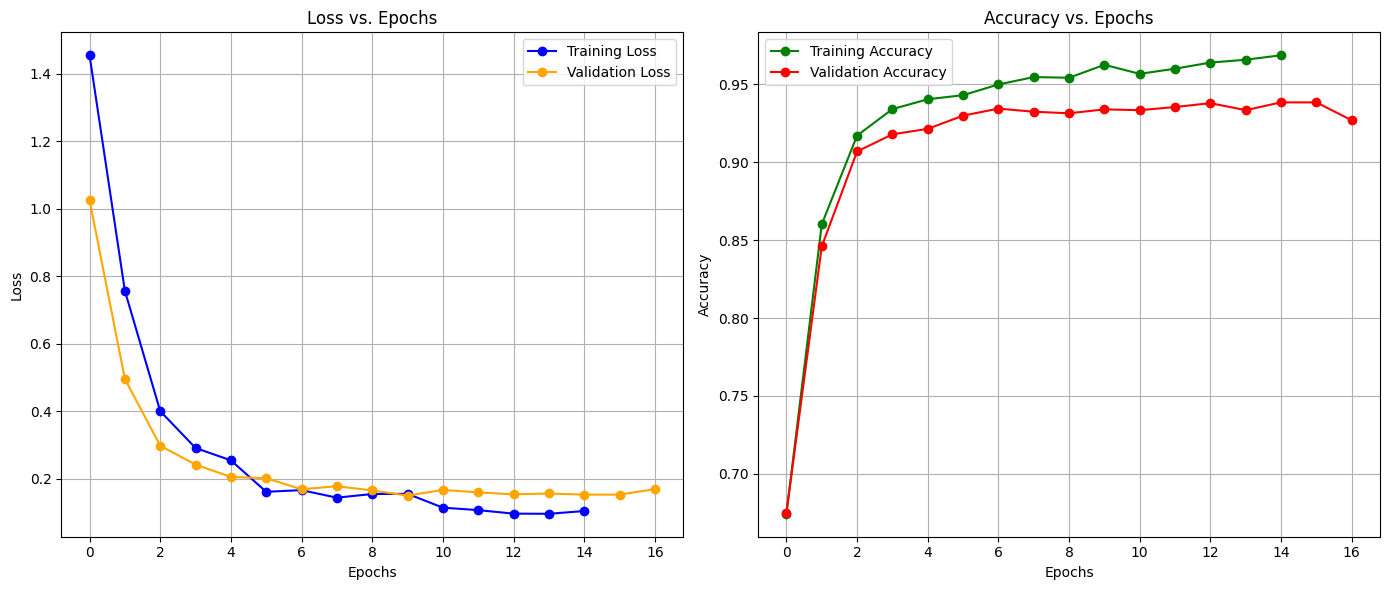

Generating classification report and confusion matrix for validation set...
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       550
         joy       0.96      0.95      0.96       704
        love       0.90      0.86      0.88       178
       anger       0.96      0.93      0.95       275
        fear       0.86      0.94      0.90       212
    surprise       0.86      0.79      0.83        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



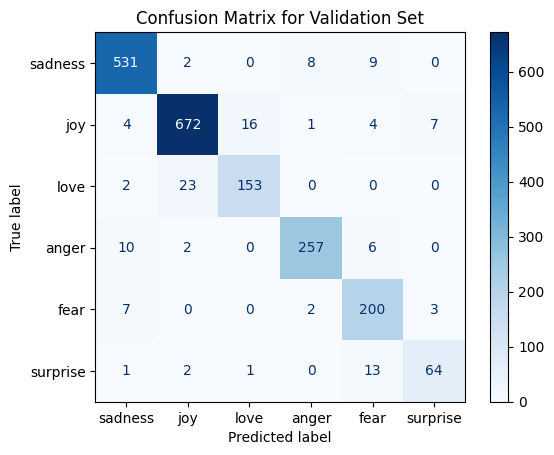

Generating classification report and confusion matrix for test set...


              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.95      0.96      0.95       695
        love       0.85      0.81      0.83       159
       anger       0.92      0.89      0.91       275
        fear       0.86      0.94      0.90       224
    surprise       0.85      0.67      0.75        66

    accuracy                           0.93      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.93      0.93      0.93      2000



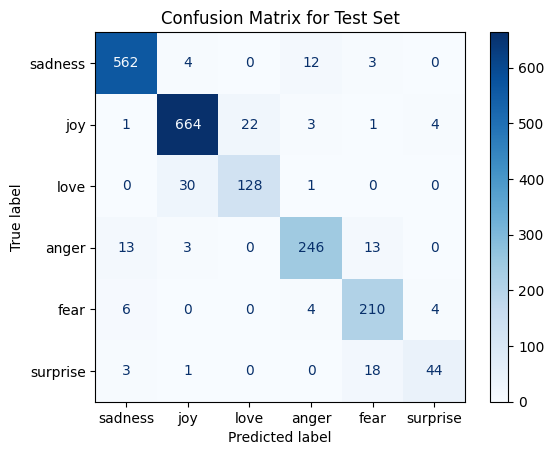

In [ ]:
# Evaluate on validation set
print("Evaluating...")
eval_results = trainer.evaluate(eval_dataset=tokenized_validation_dataset)
print(f"Validation Loss: {eval_results['eval_loss']}")

# Evaluate on test set
print("Final Evaluation on Test Set...")
test_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Loss: {test_results['eval_loss']}")

# Classification report and confusion matrix on validation set
print("Generating classification report and confusion matrix for validation set...")
predictions = trainer.predict(tokenized_validation_dataset)
report = classification_report(predictions.label_ids, np.argmax(predictions.predictions, axis=1), target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(report)

cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Classification report and confusion matrix on test set
print("Generating classification report and confusion matrix for test set...")
test_predictions = trainer.predict(tokenized_test_dataset)
test_report = classification_report(test_predictions.label_ids, np.argmax(test_predictions.predictions, axis=1), target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(test_report)

test_cm = confusion_matrix(test_predictions.label_ids, np.argmax(test_predictions.predictions, axis=1))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
test_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()

# Results

After all the models were trained, we compared the results of the four models. In terms of the accuracy of different emotion categories, Bert model has the best score in the other 5 categories except for the Fear category, which is slightly inferior to the CNN model.

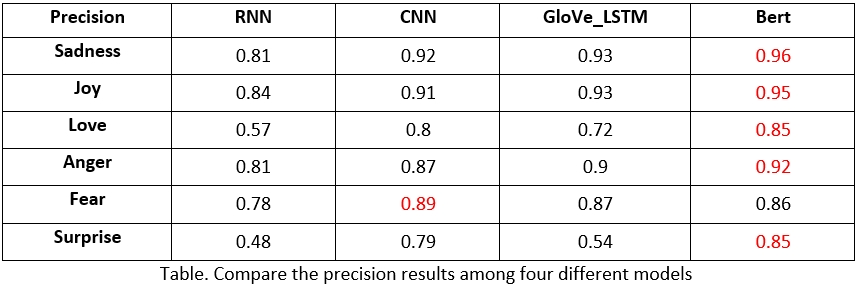

However, when comparing the Recall index of these four types of models, we found that the performance of Bert model is still excellent. However, the score for the Love and Surprise classes is slightly lower than the GloVe_LSTM model.

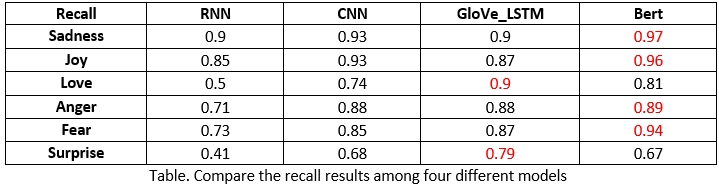

This point is also confirmed in the confusion matrix of the model. Bert only correctly classified 128 Love samples, and 30 samples were incorrectly classified as Joy. For the Surprise class, it also made only 44 correct classification predictions, while the GloVe_LSTM model made 143 and 52 correct prediction classifications, respectively.

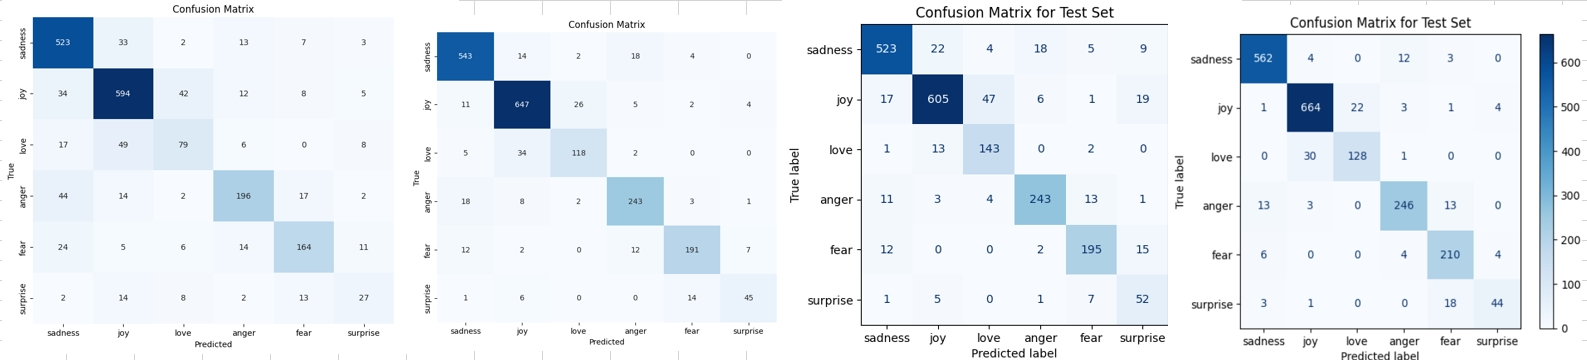
<div align="center">
Image: The Confusion Matrices among RNN, CNN, GloVe_LSTM and Bert
</div>

Finally, due to the overall high scores of Bert model in Precision and Recall, Bert model has the best scores in all 6 categories of F1-Score obtained.

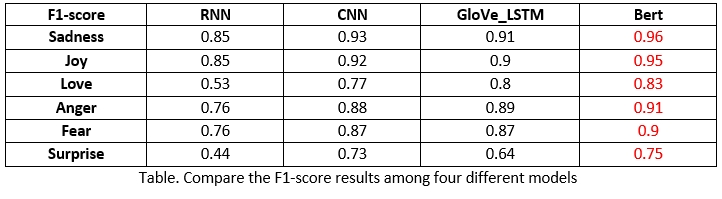

In addition, we also tried to compare the accuracy of different models on the test data set. As shown in the figure below, the performance of RNN is still the least impressive only 0.79, while the performance of CNN and GloVe is almost 0.89 and 0.88 respectively. Finally, the performance of Bert model is the best, reaching 0.93.

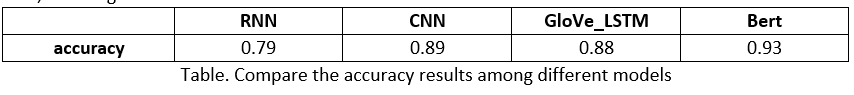

In summary, we believe that Bert model has the best performance in the task of emotional text classification. And it achieved the highest accuracy scored of 0.93, demonstrating excellent overall performance in emotion classification. The precision and recall rates were particularly high for sadness (precision: 0.96, recall: 0.97) and joy (precision: 0.95, recall: 0.96), indicating that emotion detection was effective.

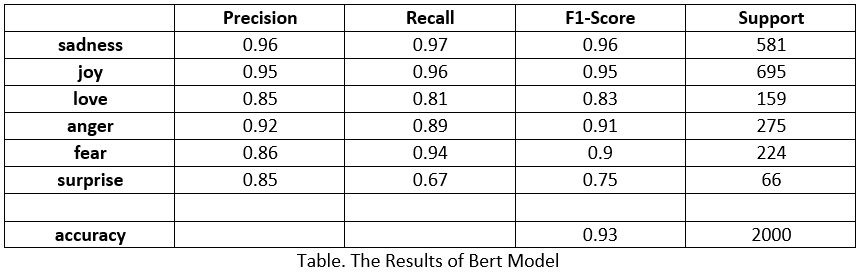


And the Confusion Matrix emphasizes that BERT correctly classifies most examples in test dataset of joy and sadness, while it seems have some misclassifies in terms of surprise.


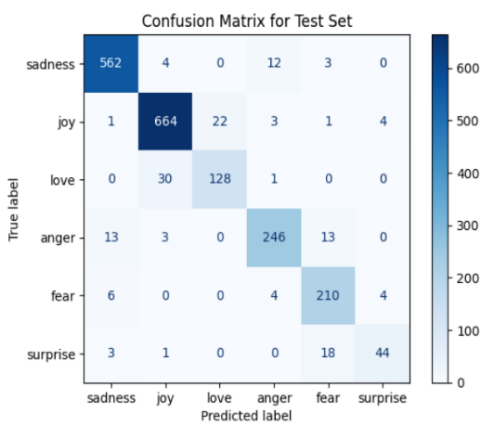

The loss curve shows in the first few rounds of training, the losses dropped rapidly. This shows that the model is quickly learning patterns in the data and significantly reducing errors. Then, with the increase of epochs, the verification loss curve remained at a low level and it also close to the training loss curve, it means that the model's performance on the verification data was similar to that on the training data, which indicate that Bert model was not overfitting and it is effective. The data in the accuracy chart has gradually increased, which also confirms what has been said before.

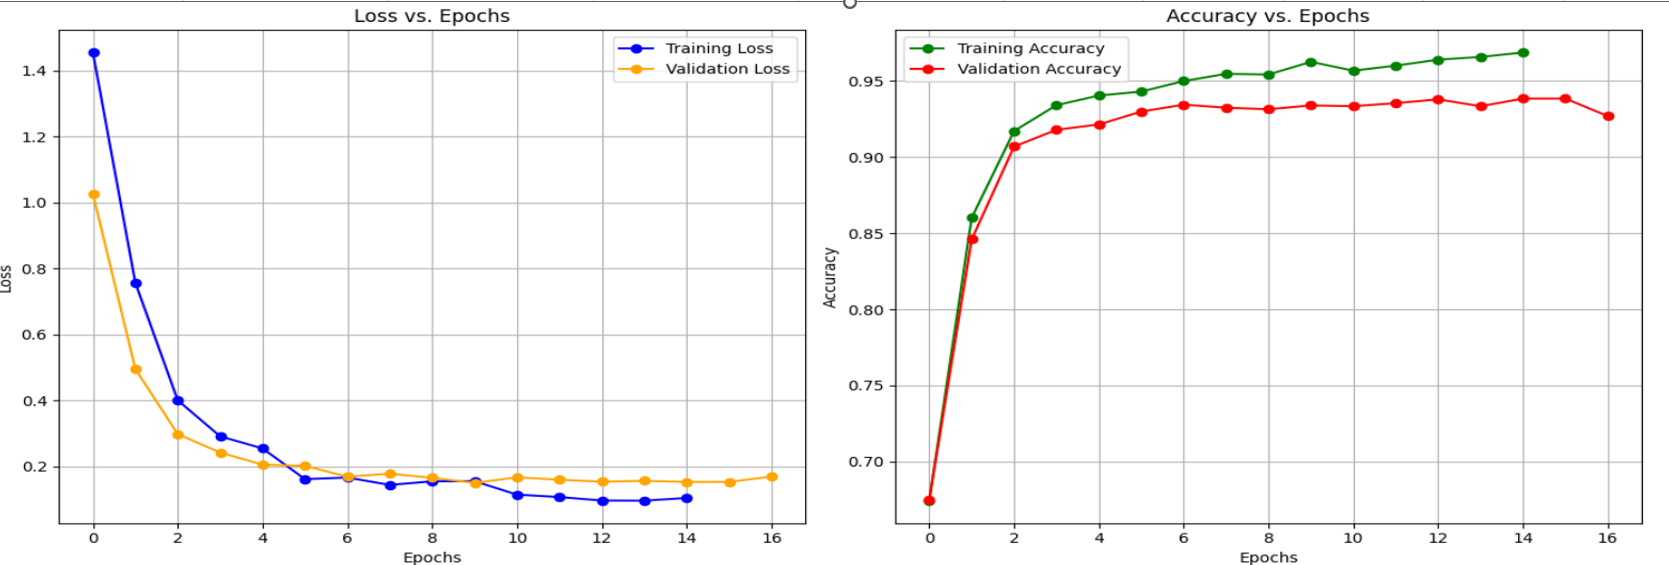

# Metrics Explanation

1. Precision<br>
The proportion of all samples predicted by the model to be positive (an emotion class) that are truly positive. The formula is as follows:
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

2. Recall<br>
The proportion of all samples that are actually positive (an emotion category) that are correctly predicted to be positive. The formula is as follows:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

3. F1-Score<br>
The harmonic average of accuracy and recall, combining the indicators of accuracy and recall. The formula is as follows:

$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
<br>
**The results of the above metrics range from 0 to 1, and the higher the value, the better the performance of the model on that metric.**

# Discussion



**Other Model:**</br>
*Advantages:*</br>
RNN model: RNN model: RNN can handle the relationship between data and time, so it has advantages in analyzing text data.</br>
CNN model: CNN can effectively extract local features and important parts of text, so in the experiment, CNN performed well on very obvious emotions such as "anger" and "fear", with accuracy rates of 0.87 and 0.89.</br>
Glove_LSTM model: GloVe provides pre-trained word vectors, which helps to enhance the vocabulary representation ability, and LSTM effectively solves the long-term dependency problem of RNN, and can obtain complex time patterns in multi-layer structures.</br></br>
*Disadvantages:*</br>
RNN model: RNN structure is relatively simple, which makes it less effective in processing complex emotional patterns.</br>
CNN model: CNN is characterized by local feature extraction, but weak in obtaining global context information, which may affect the model's comprehensive understanding of complex emotions. All of these make CNN inferior to the Bert model in making fuzzy emotional judgments such as "love" and "surprise".</br>
Glove_LSTM model: LSTM model has a high computational cost and requires more training and resources. And because it relies on pre-trained word vectors, the recognition rate of "surprise" emotion is low (because the emotional sentence "surprise" is very similar to "fear").</br></br>

**BERT:**</br>
*Advantages:*</br>
BERT model: BERT model: The BERT model has great advantages in text processing tasks such as sentiment classification because its main feature is the use of a bidirectional (dual-channel) Transformer architecture, which can simultaneously capture contextual information in the text through a self-attention mechanism. This bidirectionality allows the BERT model to understand the semantic environment of each word in a sentence, thereby generating more accurate text features, especially for dealing with complex and varied emotional expression tasks. Moreover, BERT shows strong generalization capabilities after pre-training on large-scale corpora. Fine-tuning through the Transformer library, BERT provides flexible training, which can optimize model performance by adjusting training parameters and using early stopping mechanisms. Finally, BERT shows excellent classification performance on a variety of sentiment categories. In particular, when identifying ambiguous or complex emotions, the accuracy is significantly better than traditional RNN, CNN, and LSTM models. These advantages make BERT ideal for sentiment analysis and other text classification tasks.</br>
Pre-training models: The pre-training BERT models which provided by Hugging Face were adopted, this pre-training model was on a large-scale corpus, showed strong generalization ability and robustness. </br></br>
*Disadvantages:*</br>
Unbalanced data: There is a problem with unbalanced categories in the dataset, with small sample sizes for certain sentiment categories, resulting in poor performance of the model on these categories.</br>
Risk of overfitting: Despite the excellent performance of BERT models, due to the limited amount of data, it is still possible for models to overfit, especially on sentiment categories with small samples.</br></br>
**Suggestions for future work:**</br>
Data enhancement: Data enhancement technology is used to generate more training samples to balance the number of samples in each emotion category, so as to improve the generalization ability of the model.</br></br>
Use a larger pre-training model: Consider using a larger pre-training model or making further fine-tuning of an existing model to improve model performance.</br></br>
Model integration: Try to integrate multiple models and combine their advantages to improve classification accuracy and robustness.
Training strategy optimization: Optimize the model training strategy by adjusting the learning rate and using regularization methods to prevent overfitting and improve the model's performance on the test set.
